In [59]:
import os
import argparse
import numpy as np
import os.path as osp
from copy import deepcopy
from easydict import EasyDict as edict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from src.cf_methods import c3lt 
from src.datasets import DatasetBuilder

from src.models.classifiers import SimpleCNNtorch
from src.evaluation.local_instability import perturb_sample
from src.utils import extract_factual_instances, filter_valid_factuals
from src.utils import seed_everything, get_config, load_model_weights
from src.utils import evaluate_classification_model, plot_boxplot

In [2]:
seed_everything()

In [3]:
import sys
sys.argv = ['']

In [10]:
repo_path = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark'
config_path = 'configs/revise_fmnist_binary.yaml'
config = get_config(osp.join(repo_path, config_path))

In [11]:
config.data.classes = [0, 2, 4, 6]
config.data.num_classes = len(config.data.classes)
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

In [12]:
# Create an args object to pass all relevant parameters 
weights_dir = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/src/cf_methods/c3lt/weights/fmnist'
# '/data/leuven/365/vsc36567/Counterfactual-Robustness-Benchmark/src/recourse_methods/c3lt/weights'
clf_dir = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/fmnist_classification/multiclass/checkpoints'
# '/data/leuven/365/vsc36567/Counterfactual-Robustness-Benchmark/src/models/weights'
log_path ='/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist/c3lt_multiclass'

args = c3lt.args.init_parser()
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.log_path = log_path
args.gen_path = osp.join(weights_dir, 'generator_fmnist.pth')
args.disc_path = osp.join(weights_dir, 'discriminator_fmnist.pth')
args.enc_path = osp.join(weights_dir, 'encoder_fmnist.pth')
args.cls_path = osp.join(clf_dir, 'fmnist__epoch=12_val_accuracy=0.84.pth')
args.dataset_path = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/data'
args.cls_1 = 0  # 6
args.cls_2 = 2  # 4
args.num_classes = 2
args.classifier_args={**config.classifier.args, 
                    'num_classes': config.data.num_classes,
                    'img_size': config.data.img_size
}
args.ndf=32
args.epochs=110
# args.cls_type = 'bce'
args.extracted_layers = ['main']
args.output = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist/c3lt_multiclass/results'

In [13]:
def dataloader_pair(args, dataset, is_train):
    """
        returns dataloaders for a class pair.

    :param args:
    :param is_train:
    :return:
    """
    dataset_1 = deepcopy(dataset)
    dataset_2 = deepcopy(dataset)

    # extract samples only of class 1
    idx_1 = dataset_1.data.targets == args.cls_1
    dataset_1.data.data = dataset_1.data.data[idx_1]
    dataset_1.data.targets = dataset_1.data.targets[idx_1]

    # extract samples only of class 2
    idx_2 = dataset_2.data.targets == args.cls_2
    dataset_2.data.data = dataset_2.data.data[idx_2]
    dataset_2.data.targets = dataset_2.data.targets[idx_2]

    dataloader_1 = DataLoader(dataset_1, batch_size=args.batch_size,
                              shuffle=is_train, pin_memory=True, drop_last=False)
    dataloader_2 = DataLoader(dataset_2, batch_size=args.batch_size,
                              shuffle=is_train, pin_memory=True, drop_last=False)

    return  dataloader_1, dataloader_2

In [14]:
dataloaders = dataloader_pair(args, ds_builder.train_dataset, is_train=True)
dataloaders_test = dataloader_pair(args, ds_builder.test_dataset, is_train=False)

# Training

In [21]:
c3lt.train.train_c3lt(args, [dataloaders, dataloaders_test])

Generator loaded!
Discriminator loaded!
Encoder loaded!
Classifier loaded!

Training Starts...

[Epoch 0/110] [TRAIN Loss: 0.87014]

EVAL [CLS loss: 0.0795]  [PROX loss: 0.0657]  [CYC Loss: 0.2356]  [ADV loss: 0.7108]  [EVAL loss: 0.1103] 
EVAL [COUT: 0.6953]  [Validity: 99.00 %]  [Proximity: 0.2752]

[Epoch 1/110] [TRAIN Loss: 0.07343]
[Epoch 2/110] [TRAIN Loss: 0.05502]
[Epoch 3/110] [TRAIN Loss: 0.05023]
[Epoch 4/110] [TRAIN Loss: 0.04617]
[Epoch 5/110] [TRAIN Loss: 0.04355]
[Epoch 6/110] [TRAIN Loss: 0.04111]
[Epoch 7/110] [TRAIN Loss: 0.03908]
[Epoch 8/110] [TRAIN Loss: 0.03736]
[Epoch 9/110] [TRAIN Loss: 0.03550]
[Epoch 10/110] [TRAIN Loss: 0.03389]

EVAL [CLS loss: 0.0059]  [PROX loss: 0.0659]  [CYC Loss: 0.1961]  [ADV loss: 0.5865]  [EVAL loss: 0.0327] 
EVAL [COUT: 0.7551]  [Validity: 99.90 %]  [Proximity: 0.2816]

[Epoch 11/110] [TRAIN Loss: 0.03256]
[Epoch 12/110] [TRAIN Loss: 0.03133]
[Epoch 13/110] [TRAIN Loss: 0.03045]
[Epoch 14/110] [TRAIN Loss: 0.02926]
[Epoch 15/110] [T

# Inference

In [15]:
import pickle
from src.evaluation.local_instability import perturb_sample

In [24]:
target_class = 4
target_class_ind = 2
initial_classes = [0, 2, 6]
device = "cuda" if torch.cuda.is_available() else "cpu"

mappers = {0: osp.join(repo_path, f'cf_output/{config.data.name}/c3lt_multiclass/results_0_4/snaps/map_0_to_{target_class_ind}_100.pt'), 
           2: osp.join(repo_path, f'cf_output/{config.data.name}/c3lt_multiclass/results_2_4/snaps/map_1_to_{target_class_ind}_100.pt'),
           6: osp.join(repo_path, f'cf_output/{config.data.name}/c3lt_multiclass/results_6_4/snaps/map_3_to_{target_class_ind}_100.pt')}

In [25]:
expl_model = c3lt.C3LTModel(args, task='multiclass')
expl_model.setup_model(mapper_weights_path=mappers)
baseline_classifier = expl_model.classifier

Classifier loaded!
Generator loaded!
Discriminator loaded!
Encoder loaded!


In [30]:
factuals, labels = extract_factual_instances(test_loader, initial_classes)
factuals, labels = filter_valid_factuals(factuals, labels, baseline_classifier, device)

## Local Instability

In [27]:
from src.evaluation.local_instability import calculate_ssim, calculate_sparsity
from src.utils import plot_perturbed_factuals_and_cf
from functools import reduce

In [28]:
noise_levels = [0.001, 0.0025, 0.005, 0.0075, 0.01]
save_dir = f'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/{config.data.name}/c3lt_multiclass'


In [32]:
n = 100
factuals_pert = {}    
indices_pert = {}

for noise_level in noise_levels:
    factuals_pert[noise_level] = perturb_sample(factuals, n_samples=1, noise_magnitude=noise_level)
    pert_sample = torch.Tensor(factuals_pert[noise_level])

    # Check whether perturbed instances lead to the same class prediction
    predictions = torch.argmax(baseline_classifier(pert_sample.to(device)), axis=1).detach().cpu()
    indices = np.where(predictions == labels)[0]
    print(f'Number of valid perturbed factuals for the added noise level {noise_level}: ', indices.shape[0])
    pert_sample = pert_sample[indices] 
    indices_pert[noise_level] = indices

Number of valid perturbed factuals for the added noise level 0.001:  1688
Number of valid perturbed factuals for the added noise level 0.0025:  1666
Number of valid perturbed factuals for the added noise level 0.005:  1630
Number of valid perturbed factuals for the added noise level 0.0075:  1617
Number of valid perturbed factuals for the added noise level 0.01:  1585


In [33]:
final_indices = reduce(np.intersect1d, list(indices_pert.values()))[:n]
factuals = factuals[final_indices] 
labels = labels[final_indices] 
factuals_pert = {k : v[final_indices] for k, v in factuals_pert.items()}

Generating counterfactrual explanations and evaluate their  validity  

In [34]:
factuals = factuals.to(device)
cfes = expl_model.get_counterfactuals(factuals, labels)

In [36]:
validity = np.where(torch.argmax(baseline_classifier(cfes), axis=1).detach().cpu() == target_class_ind)[0]
validity = validity.shape[0] / cfes.shape[0]
print('Validity of the generated explanations:', validity)

Validity of the generated explanations: 1.0


In [37]:
cfes_pert = {}

for noise_level in noise_levels:
    pert_sample = torch.Tensor(factuals_pert[noise_level]).to(device)
    cfes_pert[noise_level] = expl_model.get_counterfactuals(pert_sample, labels) 

In [39]:
validity_list = []
for noise_level in noise_levels:
    predictions = torch.argmax(baseline_classifier(torch.Tensor(cfes_pert[noise_level])), axis=1).detach().cpu()
    indices = np.where(predictions == target_class_ind)[0]
    validity = indices.shape[0] / predictions.shape[0]
    validity_list.append(validity)
    print(f'Validity for the added noise level {noise_level}: ',  validity)

with open(osp.join(save_dir, f'fmnist_{target_class}_validity.pkl'), 'wb') as f:
    pickle.dump(validity_list, f)

Validity for the added noise level 0.001:  1.0
Validity for the added noise level 0.0025:  1.0
Validity for the added noise level 0.005:  1.0
Validity for the added noise level 0.0075:  1.0
Validity for the added noise level 0.01:  1.0


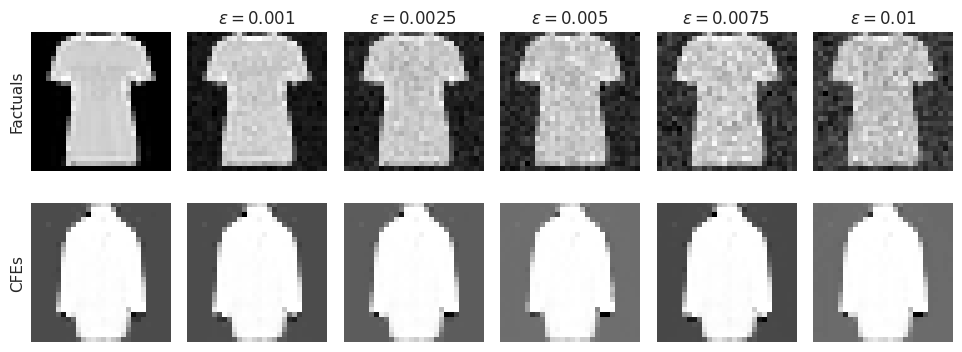

In [44]:
ind = 99
factuals_pert_list = [factuals_pert[noise_level][ind] for noise_level in noise_levels]
cfes_pert_list = [cfes_pert[noise_level][ind].detach().cpu() for noise_level in noise_levels]
plot_perturbed_factuals_and_cf(factuals[ind].cpu(), factuals_pert_list, 
                               cfes[ind].cpu(), cfes_pert_list,
                               noise_levels)

In [45]:
instability_l1_list = []
ssim_list = []

for noise_level, cfe_pert_list in cfes_pert.items():
    l1_temp = []
    ssim_temp = []
    for i in range(len(cfes)):
        cf = cfes[i].detach().cpu()
        cf_pert = cfe_pert_list[i].detach().cpu()

        if len(cf) == 0:
            continue
        if len(cf_pert) == 0:
            continue

        cf_tensor = torch.Tensor(cf)
        cf = cf_tensor.permute(1, 2, 0).flatten()

        cf_pert_tensor = torch.Tensor(cf_pert)
        cf_perturbed = cf_pert_tensor.permute(1, 2, 0).flatten()        

        l1_distance = sum(abs(cf - cf_perturbed)).item() 
        l1_temp.append(l1_distance)

        ssim = calculate_ssim(cf_tensor.unsqueeze(0), cf_pert_tensor.unsqueeze(0)).item()
        ssim_temp.append(ssim)

    instability_l1_list.append(l1_temp)
    ssim_list.append(ssim_temp)
        

with open(osp.join(save_dir, f'{config.data.name}_{target_class}_li_l1.pkl'), 'wb') as f:
    pickle.dump(instability_l1_list, f)

with open(osp.join(save_dir, f'{config.data.name}_{target_class}_ssim.pkl'), 'wb') as f:
    pickle.dump(ssim_list, f)

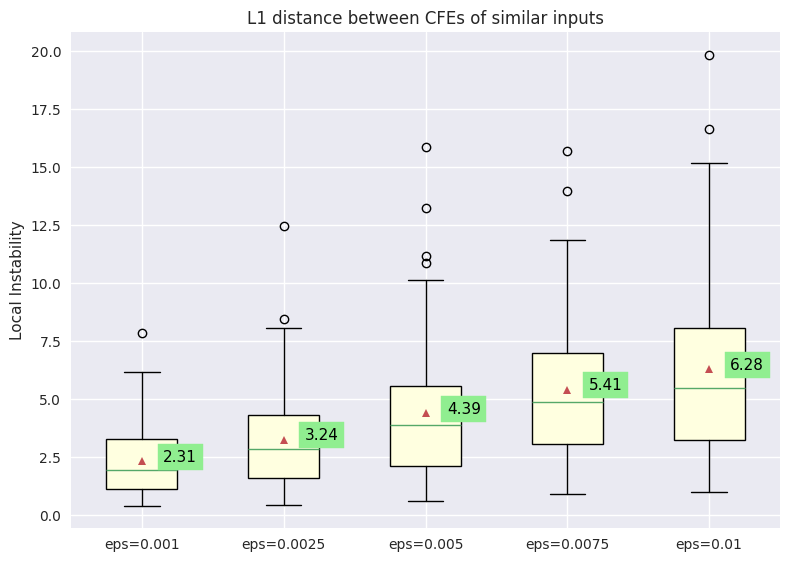

In [46]:
plt.style.use("seaborn-v0_8")


plot_boxplot(data=instability_l1_list, mean_values=np.round(np.mean(instability_l1_list, axis=1), 2),
             tick_labels=[f'eps={noise_level}' for noise_level in noise_levels],
             y_label='Local Instability', colors=['lightyellow'], title='L1 distance between CFEs of similar inputs')

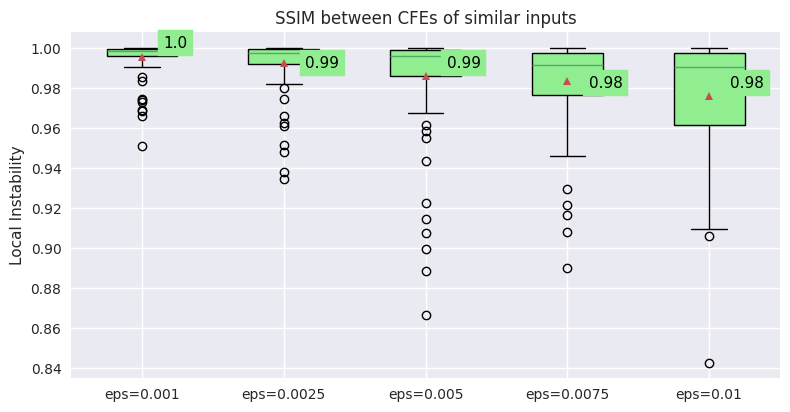

In [47]:
plt.rcParams['figure.figsize'] = [8, 4]

plot_boxplot(data=ssim_list, mean_values=np.round(np.mean(ssim_list, axis=1), 2),
             tick_labels=[f'eps={noise_level}' for noise_level in noise_levels],
             y_label='Local Instability', colors=['lightgreen'], title='SSIM between CFEs of similar inputs')

## Local Lipschitz Continuity

In [52]:
original_points = factuals # factuals_tensor[:n]
original_cfes = cfes
print("Are the lengths of initial points (factuals) and CFEs generated for them equal :", len(original_cfes) == original_points.shape[0])


Are the lengths of initial points (factuals) and CFEs generated for them equal : True


In [53]:
i = 0
lip_estimates = []
noise_magnitude = 0.001

original_points = original_points.detach().cpu()
original_cfes = original_cfes.detach().cpu()
for original_point, original_cfe in tqdm(zip(original_points[:30], original_cfes[:30])):

    neighbor_points = perturb_sample(original_point.unsqueeze(0), n_samples=30, noise_magnitude=noise_magnitude) 
    neighbor_points = torch.Tensor(neighbor_points).to(device)  
    neighbor_cfes = expl_model.get_counterfactuals(neighbor_points, labels).detach().cpu() 
    neighbor_points = neighbor_points.detach().cpu() 

    lip_estimate = 0
    for m, p in tqdm(zip(neighbor_cfes, neighbor_points)):
        num = np.linalg.norm((original_cfe - m).flatten(), ord=2) 
        denom = np.linalg.norm((original_point - p).flatten(), ord=2)
        lip = num / denom
        lip_estimate = max(lip, lip_estimate)
 
    lip_estimates.append(lip_estimate.item())
    i += 1

30it [00:00, 15994.55it/s]
30it [00:00, 21147.75it/s]
30it [00:00, 22700.54it/s]
30it [00:00, 20181.09it/s]
30it [00:00, 20849.90it/s]
30it [00:00, 22795.13it/s]
30it [00:00, 22762.14it/s]
30it [00:00, 19856.26it/s]
30it [00:00, 22890.51it/s]
30it [00:00, 23062.52it/s]
30it [00:00, 22758.02it/s]
30it [00:00, 23202.86it/s]
30it [00:00, 22965.71it/s]
30it [00:00, 22848.94it/s]
30it [00:00, 22965.71it/s]
30it [00:00, 22663.75it/s]
30it [00:00, 22655.59it/s]
30it [00:00, 23087.91it/s]
30it [00:00, 22203.83it/s]
30it [00:00, 8633.81it/s]
30it [00:00, 22869.71it/s]
30it [00:00, 22627.07it/s]
30it [00:00, 22890.51it/s]
30it [00:00, 22160.82it/s]
30it [00:00, 23519.46it/s]
30it [00:00, 22574.29it/s]
30it [00:00, 20058.84it/s]
30it [00:00, 21031.11it/s]
30it [00:00, 22869.71it/s]
30it [00:00, 22882.18it/s]
30it [00:06,  4.53it/s]


In [54]:
with open(osp.join(save_dir, f'{config.data.name}_{target_class}_lle.pkl'), 'wb') as f:
        pickle.dump(lip_estimates, f)

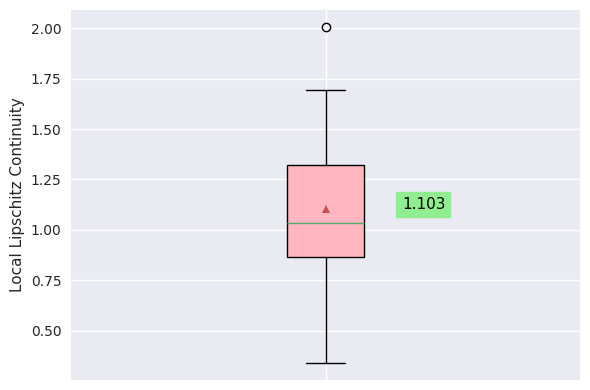

In [55]:
plt.rcParams['figure.figsize'] = [6, 4]
plot_boxplot(data=lip_estimates, mean_values=[np.round(np.mean(lip_estimates), 5)],
             tick_labels=[f''],
             y_label='Local Lipschitz Continuity', colors=['lightpink'], title='')

## Invalidation Rate

In [56]:
classifiers_weights_dir = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/fmnist_classification/multiclass/checkpoints/mc_all'


classifiers_list = []
for clf_weights in os.listdir(classifiers_weights_dir):
    cnn_perturbed = SimpleCNNtorch(**args.classifier_args)
    # load_model_weights(model=cnn_perturbed, weights_path=osp.join(classifiers_weights_dir, clf_weights))
    checkpoint = torch.load(
                    osp.join(classifiers_weights_dir, clf_weights), weights_only=False,
                    map_location=torch.device(device)
                )
            
    cnn_perturbed.load_state_dict(checkpoint)
    classifiers_list.append(cnn_perturbed)
    evaluate_classification_model(cnn_perturbed, dataloader=test_loader, num_classes=config.data.num_classes)

Accuracy for the test dataset: 81.176%
Accuracy for the test dataset: 80.680%
Accuracy for the test dataset: 81.052%
Accuracy for the test dataset: 81.597%
Accuracy for the test dataset: 79.886%
Accuracy for the test dataset: 81.076%
Accuracy for the test dataset: 79.712%
Accuracy for the test dataset: 81.672%
Accuracy for the test dataset: 80.556%
Accuracy for the test dataset: 80.630%


In [60]:
validity_list = []
invalidation_rate_list = []

for i, classifier in enumerate(classifiers_list):
    validity = 0
    invalidation_rate = 0
    total_found_cfs = 0
    
    classifier.eval()
    with torch.no_grad():
        classifier = classifier.to(device)

        baseline_pred = torch.argmax(baseline_classifier(cfes), axis=1)
        alternative_pred = torch.argmax(classifier(cfes), axis=1)
    
    invalidation_rate = np.where(baseline_pred.detach().cpu() != alternative_pred.detach().cpu())[0].shape[0] / baseline_pred.shape[0]
    validity = np.where(alternative_pred.detach().cpu() == target_class_ind)[0].shape[0] / alternative_pred.shape[0]

    # invalidation_rate /= total_found_cfs
    invalidation_rate_list.append(invalidation_rate)
    validity_list.append(validity)
    print(f'Model {i}: IR={invalidation_rate}, validity={validity}')

print('Average IR : {:.3f} +- {:.3f}'.format(np.mean(invalidation_rate_list), np.std(invalidation_rate_list)))
print('Average VaR : {:.3f} +- {:.3f}'.format(np.mean(validity_list), np.std(validity_list)))

Model 0: IR=0.0, validity=1.0
Model 1: IR=0.0, validity=1.0
Model 2: IR=0.0, validity=1.0
Model 3: IR=0.0, validity=1.0
Model 4: IR=0.0, validity=1.0
Model 5: IR=0.0, validity=1.0
Model 6: IR=0.0, validity=1.0
Model 7: IR=0.0, validity=1.0
Model 8: IR=0.0, validity=1.0
Model 9: IR=0.0, validity=1.0
Average IR : 0.000 +- 0.000
Average VaR : 1.000 +- 0.000


## Stability


In [62]:
k = 1000
sigma = 0.001

average_stability_list = []
for i, classifier in enumerate(classifiers_list):
    stability_list = []
    for cfe in cfes:

        cfe = torch.Tensor(cfe).unsqueeze(0).detach().cpu()
        cfe_sampled = torch.Tensor(perturb_sample(cfe, n_samples=k, noise_magnitude=sigma))

        with torch.no_grad():
            cf_logits = classifier(cfe.to(device))
            cf_probabilities = F.softmax(cf_logits, dim=-1)[:, target_class_ind]

            cf_sampled_logits = classifier(cfe_sampled.to(device))
            cf_sampled_probabilities = F.softmax(cf_sampled_logits, dim=-1)[:, target_class_ind]
        
        model_variance = abs(cf_probabilities - cf_sampled_probabilities)

        stability = (cf_sampled_probabilities - model_variance).mean()
        stability_list.append(stability.item())

    avg_i_stability = np.mean(stability_list)
    print(f'Stability of the model {i}: {avg_i_stability.round(3)} +- {np.std(stability_list).round(5)}')
    average_stability_list.append(avg_i_stability)

Stability of the model 0: 0.996 +- 0.00506
Stability of the model 1: 0.998 +- 0.00083
Stability of the model 2: 0.998 +- 0.0007
Stability of the model 3: 0.998 +- 0.00076
Stability of the model 4: 0.998 +- 0.00118
Stability of the model 5: 0.999 +- 0.00031
Stability of the model 6: 1.0 +- 0.00023
Stability of the model 7: 1.0 +- 0.00014
Stability of the model 8: 0.993 +- 0.00391
Stability of the model 9: 0.999 +- 0.00108


In [63]:
print('Average stability : {:.3f} +- {:.3f}'.format(np.mean(average_stability_list).round(3), 
                                             np.std(average_stability_list).round(3)))

Average stability : 0.998 +- 0.002


## LOF

In [64]:
from src.evaluation.lof import estimate_anom_cfe_in_target_class

In [65]:
cfes_array = cfes.detach().cpu().numpy()

In [66]:
target_class_ascores, target_class_classes = estimate_anom_cfe_in_target_class(5, [target_class_ind], -1.1, test_loader, cfes_array)
print('Average negative LOF (the lower values the more anomaluous): {:.3f} +- {:.3f}'.format(np.mean(target_class_ascores), 
                                                                                            np.std(target_class_ascores)))

Average negative LOF (the lower values the more anomaluous): -1.297 +- 0.067


In [67]:
all_class_ind = list(range(config.data.num_classes))
anomaly_scores, anomaly_classes = estimate_anom_cfe_in_target_class(5, all_class_ind, -1.1, test_loader, cfes_array)
print('Average negative LOF (the lower values the more anomaluous): {:.3f} +- {:.3f}'.format(np.mean(anomaly_scores), np.std(anomaly_scores)))

Average negative LOF (the lower values the more anomaluous): -1.326 +- 0.070


In [68]:
with open(osp.join(save_dir, f'fmnist_{target_class}_ir_var_rs_lof.pkl'), 'wb') as f:
    pickle.dump({'ir': (np.mean(invalidation_rate_list), np.std(invalidation_rate_list)),
                'var': (np.mean(validity_list), np.std(validity_list)),
                'rs': (np.mean(average_stability_list), np.std(average_stability_list)),
                'lof_target_class': (np.mean(target_class_ascores), np.std(target_class_ascores)),
                'lof_test_set': (np.mean(anomaly_scores), np.std(anomaly_scores))
                }, f)